# GARLIC

General-purpose Adaptive Richardson-Lucy Image Characterisation

# 1. Initialisation

## Import libraries and scripts

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import AutoMinorLocator

import ipywidgets as widgets
from IPython.display import display

import numpy as np
from time import time
from scipy import ndimage

import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

Plotting:

In [2]:
def new_figure(fig_name, figsize=(10, 5), nrows=1, ncols=1, sharex='col', sharey='row', gridspec_kw={'hspace': 0, 'wspace': 0}):
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=figsize)
    axes = fig.subplots(nrows=nrows, ncols=ncols, squeeze=False,
                        sharex=sharex, sharey=sharey,
                        gridspec_kw=gridspec_kw
                       )
    fig.set_tight_layout(True)
    for ax in axes.flat:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')

    fig.suptitle(fig_name)
    
    return fig, axes

In [3]:
default_cmap = plt.get_cmap("gist_earth").copy()
default_cmap.set_bad('gray')


def colour_map(ax, cblabel, data, cmap=default_cmap, norm=None, xlabel=None, x=None, ylabel=None, y=None):
    
    if norm is None:
        percentiles = np.array([1, 16, 50, 84, 99])
        ticks = np.nanpercentile(data, percentiles)
        linthresh = np.median(data[data > 0])
        norm = colors.SymLogNorm(vmin=ticks[0], vmax=ticks[-1], linthresh=linthresh)
    else:
        ticks = None
    if y is None:
        y = np.arange(data.shape[0])
    if x is None:
        x = np.arange(data.shape[1])

    im = ax.imshow(data,
                   extent=(x[0]-(x[1]-x[0])/2, x[-1]+(x[-1]-x[-2])/2, y[0]-(y[1]-y[0])/2, y[-1]+(y[-1]-y[-2])/2),
                   interpolation='nearest', origin='lower',
                   cmap=cmap,
                   norm=norm,
                  )
    #ax.set_aspect('auto')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    cb = fig.colorbar(im, ax=ax, orientation='vertical', shrink=.9)
    cb.ax.set_ylabel(cblabel)
    if ticks is not None:
        cb.ax.set_yticks(ticks=ticks, labels=[f'{value:.3g} ({percent}%)' for value, percent in zip(ticks, percentiles)])
    cb.ax.tick_params(labelsize='small')
    
    return im, cb


## Read data

In [4]:
importlib.reload(scripts.read_data)
object_name, data, true_spectrum = scripts.read_data.run(11, (0, 0, 1))

Read dataset 11: "Sky spectrum" (7341,) (0.0121 s)


# 2. Multi-scale RL

## Parameters
(and reasonable defaults)

In [5]:
resolution_boost = 4
n_radii = 100

In [6]:
min_scale = resolution_boost
#max_scale = data.size * resolution_boost
max_scale = np.sqrt(data.size * resolution_boost)

In [7]:
noise_fraction = .01
max_iter = 100  # just for safety

## RL loop

Automatically set smoothing radii:

In [8]:
#initial_guess = np.linspace(min_scale, max_scale, n_radii)
initial_guess = np.logspace(np.log10(min_scale), np.log10(max_scale), n_radii)
smoothing_radii = initial_guess

In [9]:
#def GARLIC(data, smoothing_radii, resolution_boost=4):
#    """General-purpose Adaptive Richardson-Lucy Image Characterisation"""

# remove NaN and negative values
offset = np.nanmin(data)
boosted_data = np.where(np.isfinite(data), data-offset, 0)

# boost resolution
original_pixel = np.arange(data.size * resolution_boost) / resolution_boost
boosted_data = np.interp(original_pixel, np.arange(data.size), boosted_data)
boosted_data = ndimage.gaussian_filter(boosted_data, resolution_boost/2)

In [10]:
'''
epsilon = 1e-3*np.min(data[data > 0])
RL = np.ones((smoothing_radii.size,) + boosted_data.shape)
rms_residual = np.inf
rms_estimate = 0
n_iter = 0
noise_estimate = np.nanstd(data[1:] - data[:-1]) / 2
while rms_residual > .5*noise_estimate:
    n_iter += 1

    estimate = np.empty_like(RL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(RL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)
    rms_estimate = np.std(np.sum(RL, axis=0))

    for i, radius in enumerate(smoothing_radii):
         RL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    print(rms_residual, np.std(RL), rms_estimate)

    cumulative_flux_fraction = np.cumsum(np.sum(RL, axis=1))
    #smoothing_radii = 10**np.interp(np.linspace(cumulative_flux_fraction[0], cumulative_flux_fraction[-1], n_radii), cumulative_flux_fraction, np.log10(smoothing_radii))
    #print(smoothing_radii)

#    return RL
'''
,

''

In [11]:
epsilon = 1e-3*np.min(data[data > 0])
SSF_amplitude = np.ones(smoothing_radii.size) / n_radii
RL = np.ones(boosted_data.shape) * np.mean(boosted_data)
multiscale_RL = RL[np.newaxis, :] * SSF_amplitude[:, np.newaxis]
old_rms_residual = 0
rms_residual = np.min(data[data > 0])
rms_estimate = 0
n_iter = 0
noise_estimate = np.nanstd(data[1:] - data[:-1]) / np.sqrt(2)
print(f'noise estimate: {noise_estimate}')
#while rms_residual > noise_fraction*noise_estimate and n_iter < max_iter:
while np.abs(old_rms_residual - rms_residual) > noise_fraction*rms_residual and n_iter < max_iter:
    n_iter += 1
    old_rms_residual = rms_residual

    #multiscale_RL = RL[np.newaxis, :] * SSF_amplitude[:, np.newaxis]
    estimate = np.empty_like(multiscale_RL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(multiscale_RL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)

    for i, radius in enumerate(smoothing_radii):
         multiscale_RL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    RL = np.nansum(multiscale_RL, axis=0)
    #SSF_amplitude = np.nanmedian(multiscale_RL/RL[np.newaxis, :], axis=1)
    SSF_amplitude = np.nanmean(multiscale_RL, axis=1)
    SSF_amplitude /= np.sum(SSF_amplitude)
    print(rms_residual)

noise estimate: 265.30359260640716
1255.019328912757
759.9807289428168
477.77600825973934
300.270385955887
197.69070193285512
140.95313415666354
110.55356782001027
94.19248675581768
84.75656661701468
78.5947417231614
73.9969515176999
70.19749257239444
66.86644088363987
63.869367404012266
61.155501615705354
58.70457960112601
56.501621117802024
54.52785701334218
52.760499356168225
51.17533066302245
49.74887045923481
48.45946387829404
47.28766646997122
46.216308465273165
45.23042519037285
44.31712319503952
43.46540902032634
42.66599621021145
41.91110348708679
41.19425515858424
40.51009224255145
39.85419988539611
39.22295398423238
38.613387783379764
38.023077674005684
37.4500464949136
36.89268226975331
36.34967037322711
35.81993736172729
35.30260491248315
34.79695238989729
34.30238654489669
33.81841687795256
33.34463535771594
32.880699490664824
32.42631810052546
31.98123948641345
31.54524180541649
31.11812555540378
30.699707964024885
30.289818992461047
29.888298597369268
29.49499488805433


In [12]:
#multiscale_RL = RL[np.newaxis, :] * SSF_amplitude[:, np.newaxis]
estimate = np.empty_like(multiscale_RL)
for i, radius in enumerate(smoothing_radii):
    estimate[i] = ndimage.gaussian_filter(multiscale_RL[i], radius)
    #print(np.std(multiscale_RL[i]), np.std(estimate[i]))
estimate = np.sum(estimate, axis=0)
rms_residual = np.std(boosted_data - estimate)
print(rms_residual, np.std(estimate), np.std(RL), np.std(boosted_data))

21.11206493592081 1254.4548657738153 1467.9476278356958 1255.019328912757


In [13]:
np.min(estimate), np.max(estimate)

(9.930484392928486e-05, 17466.742610843878)

In [14]:
'''
fig, axes = new_figure('smoothing_radii')

ax = axes[0, 0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('initial guess')
ax.set_ylabel('final smoothing radii')
ax.plot(initial_guess, smoothing_radii, 'k+-')
'''
,

''

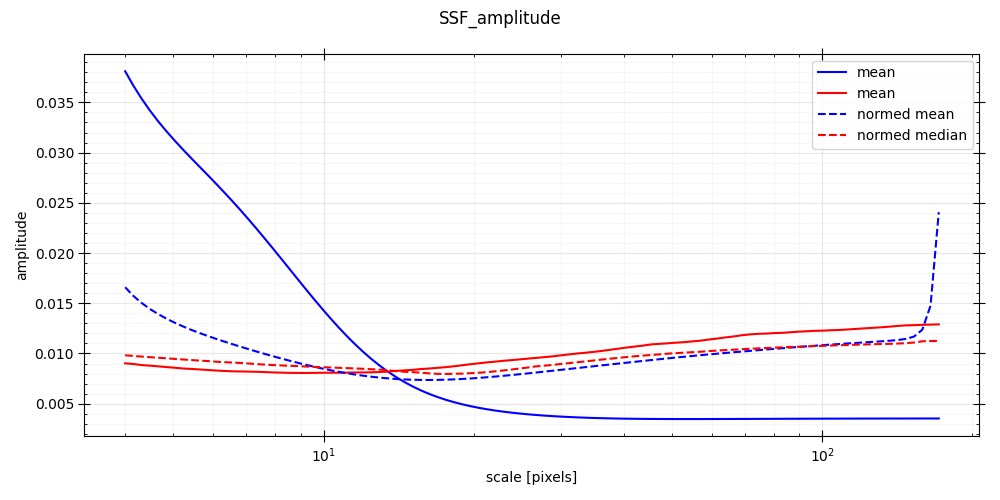

In [15]:
fig, axes = new_figure('SSF_amplitude')

ax = axes[0, 0]
ax.set_xlabel('scale [pixels]')
ax.set_xscale('log')
ax.set_ylabel('amplitude')
#ax.set_yscale('log')

a_mean = np.mean(multiscale_RL, axis=1)
a_mean /= np.sum(a_mean)
ax.plot(smoothing_radii, a_mean, 'b-', label='mean')
a_median = np.median(multiscale_RL, axis=1)
a_median /= np.sum(a_median)
ax.plot(smoothing_radii, a_median, 'r-', label='mean')

norm = np.sum(multiscale_RL, axis=0)
norm = multiscale_RL / norm[np.newaxis, :]
a_normed_mean = np.mean(norm, axis=1)
a_normed_median = np.median(norm, axis=1)
ax.plot(smoothing_radii, a_normed_mean, 'b--', label='normed mean')
ax.plot(smoothing_radii, a_normed_median, 'r--', label='normed median')
ax.legend()


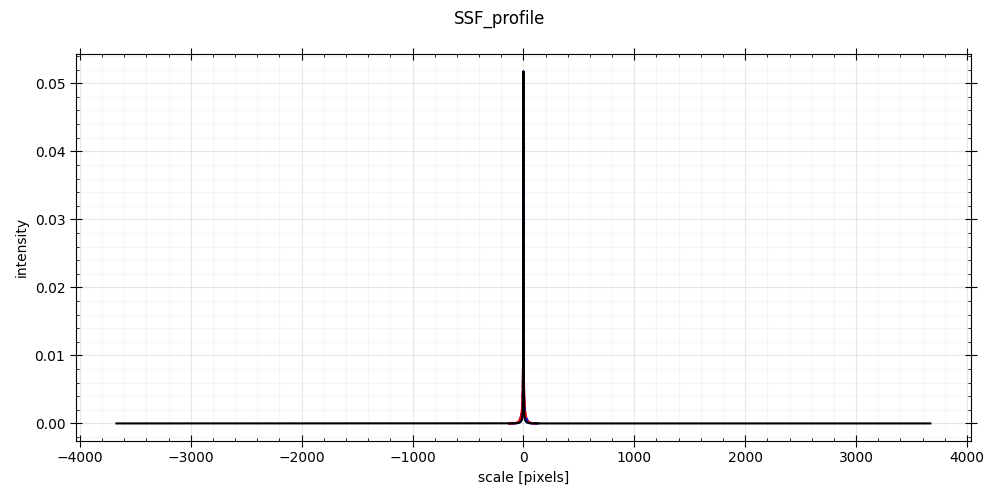

In [16]:
fig, axes = new_figure('SSF_profile')

ax = axes[0, 0]
ax.set_xlabel('scale [pixels]')
#ax.set_xscale('log')
ax.set_ylabel('intensity')
#ax.set_yscale('log')

delta = np.zeros_like(boosted_data)
delta[delta.size//2] = 1
profile = np.zeros_like(delta)
for radius, amplitude in zip(smoothing_radii, SSF_amplitude):
    profile += amplitude * ndimage.gaussian_filter(delta, radius)
#profile /= n_radii

L = 3*smoothing_radii[-1]
x = np.arange(-L, L+.5)
original_x = x / resolution_boost

def SSF_profile(amplitudes):
    profile = np.zeros_like(x)
    for radius, amplitude in zip(smoothing_radii, amplitudes):
        profile += amplitude * np.exp(-.5*(x/radius)**2) / radius
    return profile / np.sqrt(2*np.pi)

ax.plot(original_x, SSF_profile(a_mean), 'b-', label='mean')
ax.plot(original_x, SSF_profile(a_median), 'r-', label='median')
ax.plot(original_x, SSF_profile(a_normed_mean), 'b--', label='normed mean')
ax.plot(original_x, SSF_profile(a_normed_median), 'r--', label='normed median')

ax.plot(original_pixel - original_pixel[original_pixel.size//2], profile, 'k-', label='SSF')

#ax.legend()


# 3. Source finding

## HOT
Hierarchical Overdensity Tree

In [45]:
importlib.reload(scripts.sort_data)
#argsorted_data, n_valid = scripts.sort_data.run(RL.ravel())
argsorted_data, n_valid = scripts.sort_data.run(multiscale_RL.ravel())

Sorted 2936400 finite measurements in ascending order (0.301 s)


In [46]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(multiscale_RL.strides)//multiscale_RL.itemsize, multiscale_RL.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(multiscale_RL, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

6 selected: 6 [ 6 20] [ 6 20]
HOT: 1393 overdensities found, 2936400 "pixels" (100%), 1 independent regions
     2.76 seconds


In [47]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
bg = catalog[3]
#max_test_stat = catalog[3]

Plot results:

In [48]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)
print(f'{n_sources} unique sourcces')

intensity_cmap = colors

1393 unique sourcces


> 21.11206493592081 28.595534044888637


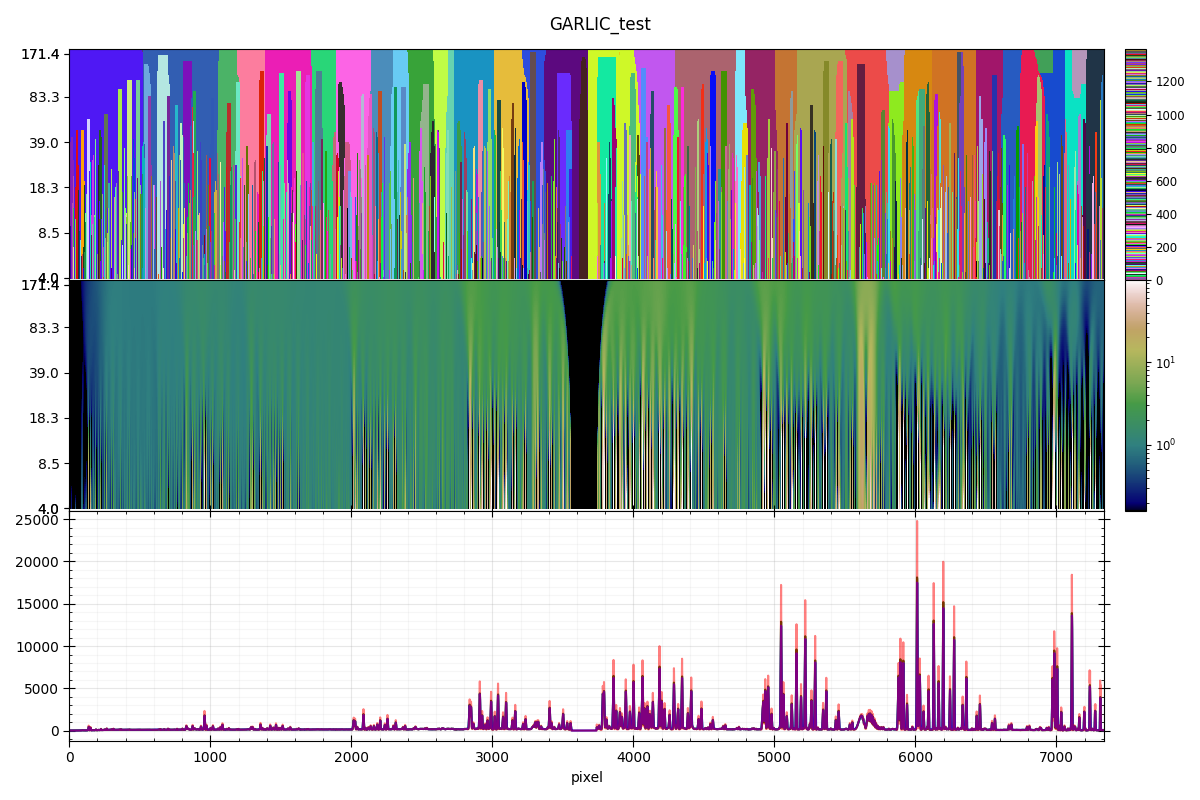

In [49]:
fig_name = 'GARLIC_test'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(12, 8))
axes = fig.subplots(nrows=3, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
fig.suptitle(fig_name)
fig.set_tight_layout(True)


ax = axes[0, 0]
#im = ax.imshow(label[np.newaxis, :],
im = ax.imshow(label,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower',
                       cmap=final_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticks(ticks)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[0, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')


ax = axes[1, 0]
im = ax.imshow(multiscale_RL,
               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
               interpolation='nearest', origin='lower',
               cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(multiscale_RL[multiscale_RL>0], 10), vmax=np.percentile(multiscale_RL[multiscale_RL>0], 99)),
              )
ax.set_aspect('auto')
ax.set_ylim(-1, n_radii+1)
ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
ax.set_yticks(ticks)
ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
cb = plt.colorbar(im, cax=axes[1, 1], orientation='vertical', shrink=.9)
cb.ax.tick_params(labelsize='small')


ax = axes[2, 0]
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
ax.grid(True, which='both')

ax.plot(true_spectrum, 'g-')
ax.plot(data, 'k-', alpha=.2)
#ax.plot(original_pixel, boosted_data + offset, 'k-')

estimate = np.empty_like(multiscale_RL)
for i, radius in enumerate(smoothing_radii):
    #ax.plot(original_pixel, RL[i], 'k-', alpha=.1)
    estimate[i] = ndimage.gaussian_filter(multiscale_RL[i], radius)
estimate = np.sum(estimate, axis=0)
rms_residual = np.std(boosted_data - estimate)
print('>', rms_residual, np.std(multiscale_RL))
ax.plot(original_pixel, estimate + offset, 'b-')
#ax.plot(original_pixel, boosted_data - estimate, 'b-', alpha=.25)
ax.plot(original_pixel, np.sum(multiscale_RL, axis=0) + offset, 'r-', alpha=.5)


ax.set_xlabel('pixel')
#ax.set_xlim(5900, 6300)

axes[2, 1].axis('off')
plt.show()

21.11206493592081


interactive(children=(BoundedIntText(value=9, description='lbl', max=1393, min=1), Output()), _dom_classes=('w…

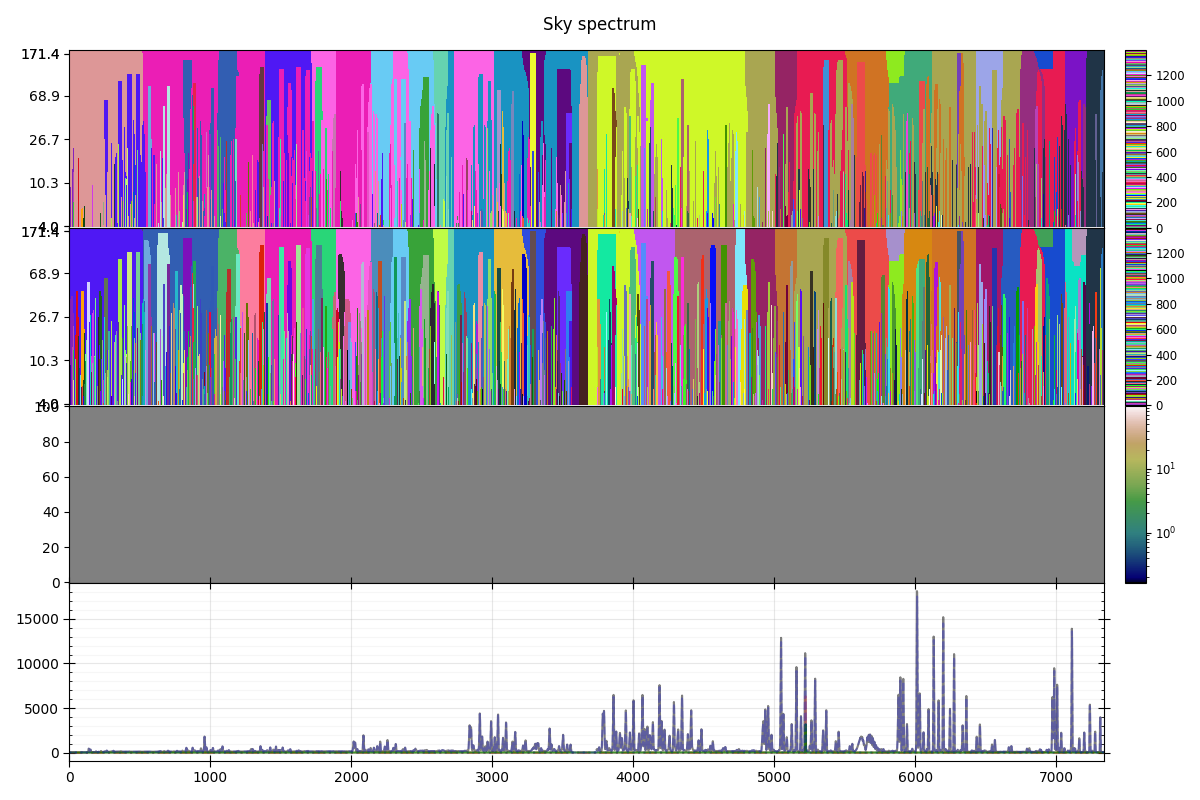

In [51]:
class Explore_lbl_1D(object):
    
    def __init__(self, fig_name, data, boosted_data, estimate, label):
        """Interactive display"""
        
        plt.close(fig_name)
        self.fig = plt.figure(fig_name, figsize=(12, 8))
        self.axes = self.fig.subplots(nrows=4, ncols=2, squeeze=False, sharex='col', gridspec_kw={'width_ratios': [1, .02], 'hspace': 0})
        self.fig.suptitle(fig_name)
        self.fig.set_tight_layout(True)

        self.original = data
        self.boosted_data = boosted_data
        self.offset = np.nanmin(data)
        #self.RL = RL
        #self.SSF = SSF
        self.total_estimate = estimate
        self.label = label

        self.ax_parent = self.axes[0, 0]
        self.ax_parent_cb = self.axes[0, 1]
        self.ax_lbl = self.axes[1, 0]
        self.ax_lbl_cb = self.axes[1, 1]

        self.ax_im = self.axes[2, 0]
        self.ax_cb = self.axes[2, 1]

        self.ax0 = self.axes[3, 0]
        self.ax0.plot(data, 'k-', alpha=.2)
        self.ax0.set_xlim(0, data.size)
        self.axes[3, 1].axis('off')

        self.widget = widgets.interactive(self.plot_lbl, lbl=widgets.BoundedIntText(value=9, min=1, max=n_sources, continuous_update=False))
        display(self.widget)


    def plot_lbl(self, lbl):
        xlim = self.ax0.get_xlim()
        ylim = self.ax0.get_ylim()

        ax = self.ax_parent
        #im = ax.imshow(parent[self.label][np.newaxis, :],
        im = ax.imshow(parent[self.label],
                       extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                       interpolation='nearest', origin='lower',
                       cmap=final_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_ylim(-1, n_radii+1)
        ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
        cb = plt.colorbar(im, cax=self.ax_parent_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        
        
        ax = self.ax_lbl
        #im = ax.imshow(self.label[np.newaxis, :],
        im = ax.imshow(self.label,
                       extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                       interpolation='nearest', origin='lower',
                       cmap=final_cmap, norm=colors.Normalize(vmin=-.5, vmax=n_sources+.5),
                      )
        ax.set_aspect('auto')
        ax.set_ylim(-1, n_radii+1)
        ticks = np.array(ax.get_yticks(), dtype=int).clip(0, n_radii-1)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{radius:.1f}' for radius in smoothing_radii[ticks]])
        cb = plt.colorbar(im, cax=self.ax_lbl_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        
        
        #epsilon = 1e-3*np.min(self.RL[self.RL > 0])
        #RL = np.ones_like(self.RL) * epsilon
        target = np.where(self.label == lbl)
        #RL = np.zeros_like(self.RL)
        #RL[target] = self.RL[target] - bg[lbl]
        RL = np.zeros_like(multiscale_RL)
        RL[target] = multiscale_RL[target] - bg[lbl]
        '''
        children = np.concatenate([
            np.where(parent == lbl)[0],
            np.where(parent[parent] == lbl)[0],
            np.where(parent[parent[parent]] == lbl)[0]
        ])
        '''
        children = np.where(parent == lbl)[0]
        for child in np.unique(children[children != lbl]):
            print(child, bg[child], bg[lbl])
            target = np.where((self.label == child) | (parent[self.label] == child))
            '''
            [0],
                np.where(parent[self.label] == child)[0],
                np.where(parent[parent[self.label]] == lbl)[0],
                np.where(parent[parent[parent[self.label]]] == lbl)[0]
            ])
            '''
            RL[target] = bg[child] - bg[lbl]
        
        self.ax0.clear()
        self.ax0.plot(self.original, 'k-', alpha=.5)
        #self.ax0.plot(original_pixel, self.boosted_data + self.offset, 'k-')

        #RL = RL[np.newaxis, :] * self.SSF[:, np.newaxis]
        estimate = np.empty_like(RL)
        for i, radius in enumerate(smoothing_radii):
            #self.ax0.plot(original_pixel, RL[i], 'k-', alpha=.1)
            estimate[i] = ndimage.gaussian_filter(RL[i], radius)
        estimate = np.sum(estimate, axis=0)
        #print(np.min(estimate))
        
        fraction = estimate/self.total_estimate
        #estimate_offset = np.sum(estimate * ((self.boosted_data+self.offset)*fraction - estimate)) / np.sum(estimate)
        final_estimate = estimate #+ estimate_offset*np.sqrt(fraction/np.max(fraction))
        #print(estimate_offset, np.max(fraction))
        #estimate = self.boosted_data*fraction + self.offset*np.mean(fraction)
        print(f'area: {np.sum(fraction):.2f} ({area[lbl]}),',
              f'flux: {np.nansum(final_estimate):.2f} ({test_stat[lbl]:.2f}),',
              f'min-max:{np.min(self.boosted_data*fraction):.2f}-{np.max(self.boosted_data*fraction):.2f},'
              f'rms:{np.sum((fraction*self.boosted_data)**2)/np.sum(self.boosted_data*fraction):.3f}')

        self.ax0.plot(original_pixel, (self.boosted_data+self.offset)*fraction, 'r-.', alpha=.5)

        self.ax0.plot(original_pixel, np.sum(RL, axis=0) + self.offset, 'r-', alpha=.25)
        self.ax0.plot(original_pixel, estimate + self.offset, 'b:', alpha=.5)
        self.ax0.plot(original_pixel, final_estimate + self.offset, 'g-', alpha=.75)
        self.ax0.plot(original_pixel, self.total_estimate + self.offset, 'b--', alpha=.25)

        ax = self.ax0
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
        ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
        ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
        ax.grid(True, which='both')
        #ax.set_yscale('log')
        ax.set_ylim(.9*self.offset, 3e5)
        '''
        '''

        self.ax_im.clear()
        im = self.ax_im.imshow(RL,
                               extent = (original_pixel[0], original_pixel[-1], -.5, n_radii+.5),
                               interpolation='nearest', origin='lower',
                               #cmap='gist_earth', norm=colors.LogNorm(vmin=np.min(RL[RL > 1e3*epsilon])))
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=1/n_radii),
                               cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(multiscale_RL[multiscale_RL>0], 10), vmax=np.percentile(multiscale_RL[multiscale_RL>0], 99)),
                               #cmap=default_cmap, norm=colors.LogNorm(vmin=np.percentile(RL[RL>0], 1), vmax=np.percentile(RL[RL>0], 99)),
                              )
        self.ax_im.set_aspect('auto')
        cb = plt.colorbar(im, cax=self.ax_cb, orientation='vertical', shrink=.9)
        cb.ax.tick_params(labelsize='small')
        self.fig.canvas.draw_idle()
        
        self.ax0.set_xlim(xlim)
        self.ax0.set_ylim(ylim)
        #self.ax0.set_xlim(5900, 6300)


if len(data.shape) == 1:
    estimate = np.empty_like(multiscale_RL)
    for i, radius in enumerate(smoothing_radii):
        estimate[i] = ndimage.gaussian_filter(multiscale_RL[i], radius)
    estimate = np.sum(estimate, axis=0)
    rms_residual = np.std(boosted_data - estimate)

    #for i, radius in enumerate(smoothing_radii):
    #     multiscale_RL[i] *= ndimage.gaussian_filter((boosted_data+epsilon) / (estimate+epsilon), radius)
    #RL = np.nansum(multiscale_RL, axis=0)
    #SSF_amplitude = np.nanmedian(multiscale_RL/RL[np.newaxis, :], axis=1)
    print(rms_residual)
    x = Explore_lbl_1D(object_name, data, boosted_data, estimate, label)

In [33]:
rms_residual

21.11206493592081

In [24]:
np.sum(data-offset)*4, np.sum(boosted_data), np.mean(boosted_data), rms_residual, np.sum(np.abs(estimate-boosted_data)), offset*boosted_data.size

(nan,
 16199234.150000002,
 551.6698729737094,
 21.11206493592081,
 213881.82673275453,
 784018.7999999999)

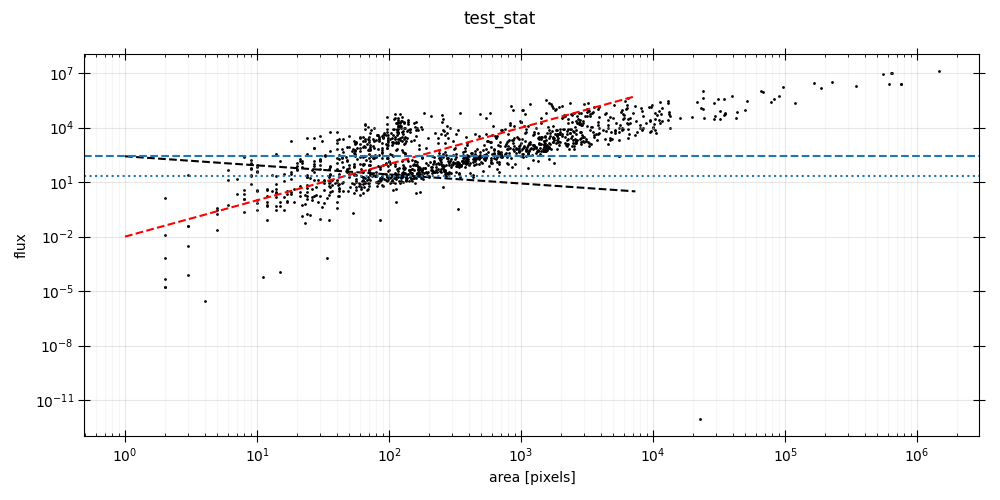

In [55]:
fig, axes = new_figure('test_stat')

ax = axes[0, 0]
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('area [pixels]')
ax.set_ylabel('flux')
ax.scatter(area, test_stat, s=1, color='k', alpha=1)
#ax.set_ylim(1e-4, 1e5)

dummy = np.logspace(0, np.log10(data.size))
ax.plot(dummy, noise_estimate/np.sqrt(dummy), 'k--')
ax.plot(dummy, .01*dummy**2, 'r--')
ax.axhline(rms_residual, ls=':')
ax.axhline(noise_estimate, ls='--')

In [26]:
noise_estimate

265.30359260640716

# -- OLD STUFF --

# 2. Noise reduction

## Sorting

In [27]:
argsorted_data.size, np.count_nonzero(mean_significance > 0)

NameError: name 'mean_significance' is not defined

# 3. Source finding

## Hierarchical Overdensity Tree (HOT)

In [ ]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

In [ ]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

In [ ]:
#cut = 1 + np.mean(mean_significance)
#cut = 30
cut = np.nansum(data)/data.size

In [ ]:
fig_name = 'test_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel
'''
ax.scatter(area, test_stat, s=1, alpha=.1)
#ax.set_yscale('symlog')
ax.set_ylim(-100, 200)
#ax.set_xlim(-.1, 20)
ax.set_xscale('log')

n_sources = np.count_nonzero((test_stat > cut) & (area > cut))
ax.axhline(cut, c='k', ls='--', label=f'{np.count_nonzero(test_stat > cut)}')
ax.axvline(cut, c='k', ls=':', label=f'{n_sources}')
'''

ax.scatter(mean_significance.flat, data.flat, s=1, alpha=.05)
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(loc='upper right')

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 8))
    
    axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=colors.SymLogNorm(linthresh=np.nanmedian(intensity)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title('Significance')
    im = ax.imshow(
        mean_significance,
        interpolation='nearest', origin='lower',
        cmap='gist_earth',
        #vmax=1,
        norm=colors.SymLogNorm(linthresh=np.nanmedian(mean_significance)),
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[1, 0]
    ax.set_title(f'segmentation')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    ax = axes[1, 1]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels], #*area[labels],
        #np.where(labels == 8448, intensity, 0),
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot', vmin=cut/2, vmax=cut,
        #cmap='seismic_r', norm=colors.LogNorm(vmin=.1*cut, vmax=10*cut),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
data_dimensionality = sorted_strides.size-1
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

if data_dimensionality == 2:
    show_segmentation(data, label)

elif data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
np.count_nonzero(label == 7838), area[7838], test_stat[7838]

In [ ]:
x = data[label == 8448]
b = np.min(x)
np.sum(x), b, area[8448], x.size, np.sum(x)-b*x.size, test_stat[8448]

In [ ]:
fig_name = 'max_test_stat'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 4))
axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                    sharex=True, sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})

ax = axes[0, 0]  # ----------------- new panel

sources = np.where(reliability > 0)
sc = ax.scatter(test_stat[sources], max_test_stat[sources]/test_stat[sources],
                marker='o', s=10, c=reliability[sources], cmap='nipy_spectral_r')

ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
top = np.where(parent == np.arange(parent.size))[0]
top

In [ ]:
def print_children(node, level, max_level=6, max_children=2):
    children = np.where(parent == node)[0]
    print(f'{level*"|"}--{node} : A={area[node]}, T={test_stat[node]:.2g}({max_test_stat[node]:.2g}) R={reliability[node]:.2g}, {children.size} children')# ({children[:max_children]})')
    decreasing_area = np.argsort(area[children])[::-1]
    if level < max_level:
        for child in children[decreasing_area][:max_children]:
            if child != node: #and reliability[child] > 0:
                print_children(child, level+1, max_level, max_children)

print_children(top[1], 0)


## Reliability

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(max_test_stat, area, plots=True)

In [ ]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [ ]:
true_overdensity = reliability > 0.43
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

## Clean-up

In [ ]:
fig_name = 'explore_significance'
plt.close(fig_name)
fig = plt.figure(fig_name, figsize=(8, 8))

axes = fig.subplots(nrows=2, ncols=2, squeeze=False,
                    sharex='col', sharey='row',
                    gridspec_kw={'hspace': 0, 'wspace': 0})
fig.suptitle(object_name)


def plot_projection(data, projection_axis, ax, transpose=False):
    intensity = np.cbrt(np.nanmean(data**3, axis=projection_axis))
    #intensity = np.nanmean(data, axis=projection_axis)
    if transpose:
        intensity = intensity.T
    print(intensity.shape)
    pmin, p50, pmax = np.nanpercentile(intensity, [1, 50, 99.9])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        cmap='rainbow',
        vmin=-pmax, vmax=pmax,
        #norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    ax.set_aspect('auto')


plot_projection(mean_significance, 0, axes[1, 0])
plot_projection(mean_significance, 2, axes[1, 1], True)
plot_projection(mean_significance, 1, axes[0, 0])


for ax in axes.flatten():
    ax.tick_params(which='both', direction='in')
    ax.grid(alpha=.5)
fig.set_tight_layout(True)
plt.show()

In [ ]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

## Explore results

### Definitions

In [ ]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
#scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
#pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
#scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
#scale_max = data.ravel()[argsorted_data[-1]]
#colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)
p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
colour_scale = colors.SymLogNorm(vmin=p16, linthresh=2*p50-p16, vmax=p100+p16)

#colour_scale = colors.LogNorm(vmin=p16, vmax=p100)

In [ ]:
n_sources = np.unique(label).size
my_cmap = np.vstack([(np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, (np.argsort(np.random.random(n_sources))+1)/n_sources, np.ones(n_sources)]).T
my_cmap[0, :] = [0., 0., 0., 1.]
final_cmap = colors.ListedColormap(my_cmap)

### Segmentation

In [ ]:
def show_parents(labels, parents, ax):
    for obj in np.unique(labels):
        if area[obj] > 10:
            y_obj, x_obj = np.unravel_index(np.nanargmax(np.where(label == obj, data, -np.inf)), data.shape)
            y_par, x_par = np.unravel_index(np.nanargmax(np.where(label == parents[obj], data, -np.inf)), data.shape)
            #print(f'{obj}, {parents[obj]}, {x_obj, y_obj}')
            ax.plot([x_obj, x_par], [y_obj, y_par], 'k+-', alpha=.5)

def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        #cmap='terrain',
        #cmap='magma',
        #cmap='gist_heat',
        cmap='gist_earth',
        #cmap='YlGn',
        norm=intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        #labels == study_object,
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax, shrink=.7)
    #show_parents(labels, parent, ax)

    '''
    ax = axes[0, 1]
    ax.set_title(object_name)
    im = ax.imshow(
        total_weight,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        new_label,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    '''
    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        #cmap='gist_heat',
        )
    cb = fig.colorbar(im, ax=ax)
    '''

    ax = axes[0, 2]
    ax.set_title(f'Test statistic')
    im = ax.imshow(
        test_stat[labels]*area[labels],
        interpolation='nearest', origin='lower',
        #cmap='nipy_spectral_r',
        #cmap='inferno_r',
        cmap='hot_r',
        norm=colors.LogNorm(vmin=1e-7, vmax=1e-3),
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

In [ ]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    axis = 0
    intensity = np.nanmean(mean_significance, axis=axis)
    #intensity = np.nanmean(data**2, axis=1)
    #intensity = np.nanmax(data, axis=1)
    #intensity = np.cbrt(np.nanmean((mean_significance-np.nanmean(mean_significance))**3, axis=axis))
    pmin, p50, pmax = np.nanpercentile(intensity, [16, 50, 99])
    intensity_scale = colors.SymLogNorm(vmin=pmin, linthresh=2*p50-pmin, vmax=pmax)
    #intensity_scale = colors.Normalize(vmin=0, vmax=1)
    show_segmentation(intensity, np.nanmax(label, axis=axis), intensity_scale)


In [ ]:
'''
'''
if plots and data_dimensionality == 3:

    mode = 0
    projection_axis = 0
    max_map = np.nanmax(label, axis=projection_axis)

    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    '''
    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    '''
    ax[0, 0].set_title('Mean significance')
    im = ax[0, 0].imshow(
        np.nanmean(mean_significance, axis=projection_axis),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
        #norm = intensity_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=projection_axis)/np.sqrt(np.nanmean(data**2, axis=projection_axis)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3, alpha=.25)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
